In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from baukit import Trace, TraceDict
import matplotlib.pyplot as plt
import numpy as np
import random
from transformers import LlamaForCausalLM, AutoTokenizer
import pandas as pd
from tokenizers import AddedToken
from utils import *

In [54]:
# 安装baukit，probe_trainer中需要（如果只用hidden_states probe也可以不装，需要把utils.py里面用到TraceDict的地方注释掉）
# !pip install git+https://github.com/davidbau/baukit

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils

In [3]:
def set_tokenizer(tk_path):
    _SPECIAL_TOKENS_DICT = {'pad_token': '</s>'}
    human = AddedToken("<human>",lstrip=False,rstrip=False,single_word=False,normalized=True)
    bot = AddedToken("<bot>",lstrip=False,rstrip=False,single_word=False,normalized=True)
    llama_tokenizer = AutoTokenizer.from_pretrained(tk_path,use_fast=False)
    llama_tokenizer.add_special_tokens(_SPECIAL_TOKENS_DICT)
    llama_tokenizer.add_special_tokens({"additional_special_tokens":[human, bot]})
    return llama_tokenizer
model = LlamaForCausalLM.from_pretrained("/path2ziyamodel").to(torch.bfloat16).cuda().eval()
llama_tokenizer = set_tokenizer("/path2ziyamodel")

Loading checkpoint shards:   0%|          | 0/28 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [5]:
df = pd.read_json("/data/test_labeled_for_probe.jsonl",lines=True)
df

,question,answer,generation,category,rank
0,潘美辰是哪个国家的创作女歌手？,台湾,"[{'text': '潘美辰是中国台湾的创作女歌手。', 'type': 'normal',...",partial-right,[{'text': '潘美辰是中国台湾的创作女歌手。她出生于台湾省，在台湾发展了她的音乐事业...
1,严新主要活动在哪些国家？,美国、加拿大等地,[{'text': '严新是一位中国籍的中医师，他的主要活动范围可能包括中国大陆、台湾地区、...,partial-right,[{'text': '严新是一位中国的医生、气功师和作家，他在中国和其他一些国家开展过活动。...
2,罗伯特·斯坦恩是哪所大学的建筑系硕士？,哥伦比亚大学,[{'text': '罗伯特·斯坦恩（Robert Stern）是美国加州大学洛杉矶分校（U...,partial-right,"[{'text': 'Robert Stern是哥伦比亚大学建筑系的硕士。', 'type'..."
3,达罗毗语系的语言分布在哪些地区?,印度南部的泰米尔纳德邦、卡纳塔克邦、安得拉邦、喀拉拉邦，印度中部和东部的一些地区，以及巴基斯...,[{'text': '达罗毗语系是一个大型的语系，包括许多不同的语言，分布在亚洲和非洲的多个...,partial-right,[{'text': '达罗毗语系（Dravidian languages）是指源自古代达罗毗...
4,晶洞形成的理论有哪些?,地质学家对晶洞形成的理论尚未达成共识。,[{'text': '晶洞是指在地壳内部形成的空洞，通常是由地下水和岩石之间的化学反应形成的...,partial-right,[{'text': '晶洞是指在地质作用过程中，由于地壳岩石的变形和裂隙扩张，使得矿物质在其...
...,...,...,...,...,...
3080,叶音是指以什么方式改读字音？,改读字音的方式,[{'text': '叶音是指以某种特定的方式改读字音，通常是为了避免发音上的不便或不自然。...,partial-right,[{'text': '叶音是指通过改变字的声调或音节来改读字音的方式。在汉语中，叶音是一种常...
3081,日本大赛的赛制是什么？,赛制采取七战四胜制，先取得四胜的球队获得总冠军。,[{'text': '日本大赛（Nippon Series）是日本职业棒球联赛中的一个系列赛...,all-wrong,[{'text': '对于问题“日本大赛的赛制是什么？”，根据上下文，我在此提供一个可能的答...
3082,维姆·德伊森贝赫是哪个国家的政治家和银行家？,荷兰,[{'text': '维姆·德伊森贝赫是荷兰的一位政治家和银行家。他于1936年出生在荷兰的...,partial-right,[{'text': '维姆·德伊森贝赫（Wim Duisenberg）是荷兰的政治家和银行家...
3083,满月圆山的海拔高度是多少？,867公尺,"[{'text': '满月圆山的海拔高度约为2,520公尺（8,272英尺）。', 'typ...",all-right,"[{'text': '满月圆山的海拔高度是1212公尺（约3978英尺）。', 'type'..."


In [41]:
all_right = df[df["category"]=="all-right"][["question","answer","category","generation"]].sample(n=200).reset_index(drop=True)
all_wrong = df[df["category"]=="all-wrong"][["question","answer","category","generation"]].sample(n=200).reset_index(drop=True)
print("all-right:",all_right.shape,"all-wrong:",all_wrong.shape)

all-right: (200, 4) all-wrong: (200, 4)


In [43]:
bs = 8
lr = 1e-4
epoch = 10
probe_trainer = ProbeTrainer(model,llama_tokenizer,bs=bs,lr=lr,epoch=epoch)

In [44]:
all_right_data = []
all_wrong_data = []
for i in range(all_right.shape[0]):
    question = all_right.loc[i,"question"]
    d = probe_trainer.get_activation_data(question,"all-right")
    all_right_data.append(d)
for i in range(all_wrong.shape[0]):
    question = all_wrong.loc[i,"question"]
    d = probe_trainer.get_activation_data(question,"all-wrong")
    all_wrong_data.append(d)
print(len(all_right_data),len(all_wrong_data))
random.shuffle(all_right_data)
random.shuffle(all_wrong_data)
n = int(0.7*(len(all_right_data)))
train = all_right_data[:n]+all_wrong_data[:n]
random.shuffle(train)
test = all_right_data[n:]+all_wrong_data[n:]
print("train:",len(train),"test:",len(test))

200 200
train: 280 test: 120


***
#### 最佳prober

In [46]:
for layer in range(model.config.num_hidden_layers):
    test_results,prober = probe_trainer.fit_one_probe(train,test,"hidden_states","last",layer)
    max_acc = max(test_results,key=lambda x:x['acc'])
    print(layer,max_acc)
    if max_acc["acc"]>0.8:
        break
print("probe:",layer,max(test_results,key=lambda x:x['acc']))

0 {'acc': 0.5, 'precision': 0.5, 'recall': 1.0, 'specificity': 0.0}
1 {'acc': 0.533, 'precision': 1.0, 'recall': 0.067, 'specificity': 1.0}
2 {'acc': 0.658, 'precision': 0.679, 'recall': 0.6, 'specificity': 0.717}
3 {'acc': 0.542, 'precision': 1.0, 'recall': 0.083, 'specificity': 1.0}
4 {'acc': 0.683, 'precision': 0.641, 'recall': 0.833, 'specificity': 0.533}
5 {'acc': 0.7, 'precision': 0.75, 'recall': 0.6, 'specificity': 0.8}
6 {'acc': 0.692, 'precision': 0.709, 'recall': 0.65, 'specificity': 0.733}
7 {'acc': 0.708, 'precision': 0.705, 'recall': 0.717, 'specificity': 0.7}
8 {'acc': 0.708, 'precision': 0.705, 'recall': 0.717, 'specificity': 0.7}
9 {'acc': 0.717, 'precision': 0.686, 'recall': 0.8, 'specificity': 0.633}
10 {'acc': 0.75, 'precision': 0.768, 'recall': 0.717, 'specificity': 0.783}
11 {'acc': 0.742, 'precision': 0.738, 'recall': 0.75, 'specificity': 0.733}
12 {'acc': 0.733, 'precision': 0.733, 'recall': 0.733, 'specificity': 0.733}
13 {'acc': 0.75, 'precision': 0.742, 'recal

In [47]:
### 保存probe参数并记录对应的模型，state名和层数
torch.save(prober.state_dict(), f'sft_0911_probe_hidden_last_layer{layer}.pt')

{'acc': 0.808, 'precision': 0.785, 'recall': 0.85, 'specificity': 0.767}


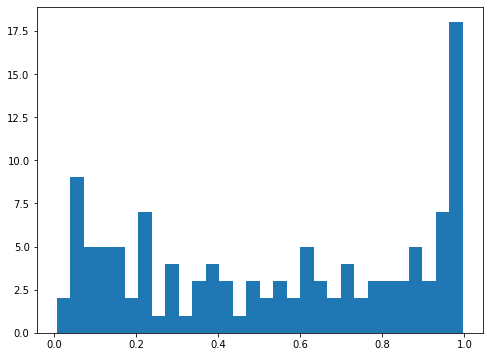

In [48]:
state,label = probe_trainer.get_state(test,"hidden_states","last",layer,None)
out,loss = prober(state,label)
result = probe_trainer.get_acc(out, label)
print(result)
plt.figure(figsize=(8,6))
score = out.squeeze().detach().numpy()
plt.hist(score,bins=30)
plt.show()

***
### probe实验1：问题的last token的hidden states（every layer）对预测模型是否能回答这个问题的acc

In [49]:
max_acc_hidden = []
for layer in range(1,model.config.num_hidden_layers+1,1):
    test_results,_ = probe_trainer.fit_one_probe(train,test,"hidden_states","last",layer)
    max_acc = max(test_results,key=lambda x:x['acc'])
    max_acc_hidden.append(max_acc)

layer: 31 probing results: {'acc': 0.825, 'precision': 0.8, 'recall': 0.867, 'specificity': 0.783}


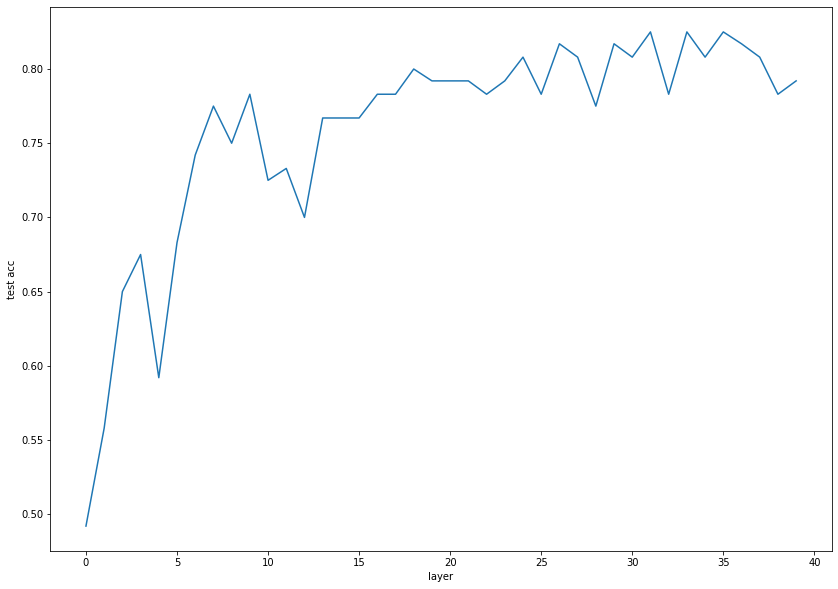

In [50]:
ind = np.argmax([d["acc"] for d in max_acc_hidden])
print("layer:",ind,"probing results:",max_acc_hidden[ind])
# plt.plot([d["acc"] for d in max_acc_mlp],label="mlp")
plt.plot([d["acc"] for d in max_acc_hidden],label="hidden")
# plt.legend()
plt.xlabel("layer")
plt.ylabel("test acc")
# plt.savefig('hidden_probe_sft0911_1.png')
plt.show()
plt.show()

***
### probe实验2：问题的last token的mlp hidden states（every layer）对预测模型是否能回答这个问题的acc

In [51]:
max_acc_mlp = []
all_mlp_results = []
for layer in range(model.config.num_hidden_layers):
    test_results,_ = probe_trainer.fit_one_probe(train,test,"mlp_wise_hidden_states","last",layer)
    max_acc = max(test_results,key=lambda x:x['acc'])
    all_mlp_results.append(test_results)
    max_acc_mlp.append(max_acc)

layer: 37 probing results: {'acc': 0.8, 'precision': 0.821, 'recall': 0.767, 'specificity': 0.833}


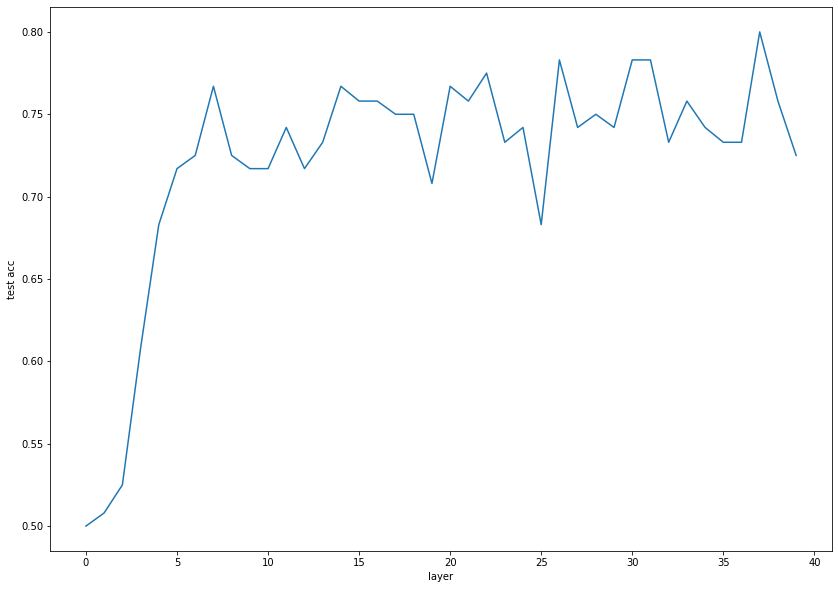

In [52]:
ind = np.argmax([d["acc"] for d in max_acc_mlp])
print("layer:",ind,"probing results:",max_acc_mlp[ind])
plt.plot([d["acc"] for d in max_acc_mlp])
plt.xlabel("layer")
plt.ylabel("test acc")
# plt.savefig('mlp_probe_sft0911_1.png')
plt.show()

## NOTE
下面的实验需要attention activation输出，使用baukit.TraceDict获取attention输出需要以下几步：
1. 在模型源码attention输出部分加入Identity层
    
    以llama模型为例，在LLaMAAttention的init中加入self.att_out = nn.Identity()，在forward中qkv计算后o计算前加入attn_output = self.head_out(attn_output)
    
    参考： https://github.com/likenneth/honest_llama/blob/master/llama/modeling_llama.py
    
2. 在utlis.py中取消对self.HEADS相关的注释

3. 重新运行初始化模型和数据的部分

***
### probe实验3：问题的last token的attention activation（every layer）对预测模型是否能回答这个问题的acc

In [13]:
max_acc_attn = []
for layer in range(model.config.num_hidden_layers):
    test_results,_ = probe_trainer.fit_one_probe(train,test,"head_wise_hidden_states","last",layer)
    max_acc = max(test_results,key=lambda x:x['acc'])
    max_acc_attn.append(max_acc)

layer: 15 probing results: {'acc': 0.689, 'precision': 0.718, 'recall': 0.622, 'specificity': 0.756}


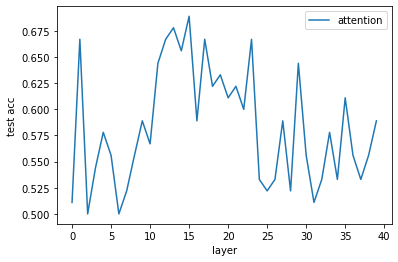

In [14]:
ind = np.argmax([d["acc"] for d in max_acc_attn])
print("layer:",ind,"probing results:",max_acc_attn[ind])
plt.plot([d["acc"] for d in max_acc_attn],label="attention")
plt.ylabel("test acc")
plt.xlabel("layer")
# plt.savefig('attn_probe_sft0911_1.png')
plt.legend()
plt.show()

***
### probe实验5：**问题**的last token 的attention activation（every head every layer）对预测模型是否能回答这个问题的acc

In [15]:
max_acc_attn = []
for layer in range(model.config.num_hidden_layers):
    print(layer)
    max_acc_attn_layer = []
    for head in range(model.config.num_attention_heads):
        test_results,_ = probe_trainer.fit_one_probe(train,test,"head_wise_hidden_states","last",layer, head)
        max_acc = max(test_results,key=lambda x:x['acc'])
        max_acc_attn_layer.append(max_acc)
    max_acc_attn.append(max_acc_attn_layer)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


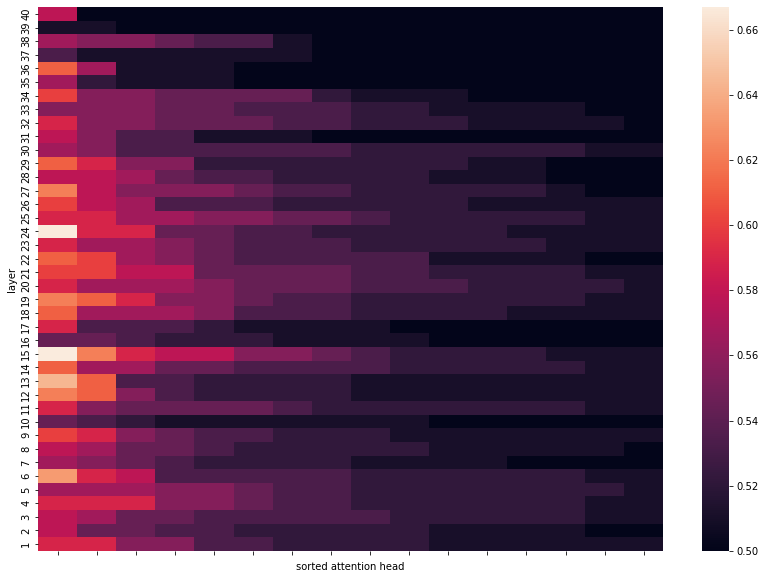

In [16]:
attn_head_acc_matrix = np.array([[d["acc"] for d in data] for data in max_acc_attn])
import seaborn as sns

sns.set_context({"figure.figsize":(14,10)})
x_axis_labels = [""]*16
# x_axis_labels = range(model.config.num_attention_heads)
y_axis_labels = range(model.config.num_hidden_layers,0,-1)

attn_head_acc_matrix_sort = [sorted(m)[::-1][:16] for m in attn_head_acc_matrix]
fig = sns.heatmap(data=attn_head_acc_matrix_sort,xticklabels=x_axis_labels,yticklabels=y_axis_labels)#, cmap="YlGnBu")
fig.set(ylabel='layer')
fig.set(xlabel='sorted attention head')

scatter_fig = fig.get_figure()
# scatter_fig.savefig("attn_head_acc_heatmap_sorted_cliped_1.png")

***